# Meta-Sampling: Estratégia de seleção de instâncias baseada em meta-aprendizado

## Imports

In [1]:
import os
import warnings 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Elaboração de meta-base 

In [2]:
DATA_DIR = '../../scripts/metabase/'

In [3]:

dfs = []
for root, _, files in os.walk(DATA_DIR):
    
    if not len(files):
        continue
        
    df = pd.concat(pd.read_csv(os.path.join(root,file)) for file in files).set_index(['dataset_id','estimator', 'query_number'])
    dfs.append(df)

In [4]:
metabase = pd.concat(dfs)
metabase

attr_conc.mean  attr_conc.sd  \
dataset_id estimator            query_number                                 
41568.0    KNeighborsClassifier 0.0                 0.266416      0.147752   
                                1.0                 0.269267      0.139688   
                                2.0                 0.235390      0.123473   
                                3.0                 0.257479      0.130911   
                                4.0                 0.247777      0.111943   
...                                                      ...           ...   
1049.0     GaussianNB           95.0                0.210486      0.182485   
                                96.0                0.155472      0.186614   
                                97.0                0.136602      0.205036   
                                98.0                0.126201      0.184579   
                                99.0                0.187922      0.147774   

                                              attr_ent.mean  attr_ent.sd  \
dataset_id estimator            query_number                               
41568.0    KNeighborsClassifier 0.0                1.985165     0.005264   
                                1.0                1.984356     0.008727   
                                2.0                1.986649     0.003917   
                                3.0                1.989122     0.005212   
                                4.0                1.993262     0.002253   
...                                                     ...          ...   
1049.0     GaussianNB           95.0               2.203295     0.897822   
                                96.0               2.200960     0.900131   
                                97.0               2.200407     0.902063   
                                98.0               2.196692     0.899106   
                                99.0               2.193601     0.896082   

                                              attr_to_inst  cat_to_num  \
dataset_id estimator            query_number                             
41568.0    KNeighborsClassifier 0.0               0.037383         0.0   
                                1.0               0.039216         0.0   
                                2.0               0.041237         0.0   
                                3.0               0.043478         0.0   
                                4.0               0.045977         0.0   
...                                                    ...         ...   
1049.0     GaussianNB           95.0              0.060359         0.0   
                                96.0              0.060855         0.0   
                                97.0              0.061360         0.0   
                                98.0              0.061873         0.0   
                                99.0              0.062395         0.0   

                                              cohesiveness.mean  \
dataset_id estimator            query_number                      
41568.0    KNeighborsClassifier 0.0                   47.761682   
                                1.0                   45.254902   
                                2.0                   42.860825   
                                3.0                   40.614130   
                                4.0                   37.867816   
...                                                         ...   
1049.0     GaussianNB           95.0                 242.624490   
                                96.0                 240.519017   
                                97.0                 238.407649   
                                98.0                 236.081835   
                                99.0                 234.439397   

                                              cohesiveness.sd  cor.mean  \
dataset_id estimator            query_number                              
41568.0    KNeighborsClassifier 0.0                  3.83

Fazendo download do arquivo:

## Treinamento de Meta-Modelo

Substituindo valores infinitos por `np.nan`

In [5]:
metabase.replace([np.inf, -np.inf], np.nan, inplace=True)

Separando uma base para teste e o restante para treinamento (LOO)

In [6]:
train_index = metabase.index.levels[0][:-1]
test_index = metabase.index.levels[0][-1:]

len(train_index), len(test_index)

(59, 1)

Separando features e rótulos (utilizando apenas o classificador SVM)

In [7]:
train_data = metabase.loc[train_index].xs("SVC", level='estimator').reset_index()
test_data = metabase.loc[test_index].xs("SVC", level='estimator').reset_index()

In [8]:
test_data

,dataset_id,query_number,attr_conc.mean,attr_conc.sd,attr_ent.mean,attr_ent.sd,attr_to_inst,cat_to_num,cohesiveness.mean,cohesiveness.sd,...,ch,int,nre,pb,sc,sil,vdb,vdu,best_strategy,best_score
0,44720.0,0.0,0.011365,0.018764,2.637889,0.372577,0.004013,0.0,461.455518,36.556053,...,317.337079,9.528633,0.646510,-0.421633,0.0,0.191343,2.040229,2.549379e-07,vote_entropy_sampling,0.626
1,44720.0,1.0,0.011369,0.018666,2.635710,0.370261,0.004027,0.0,459.989933,36.438445,...,288.793206,9.304015,1.550497,-0.536494,0.0,0.207025,1.660453,4.733878e-07,uncertainty_batch_sampling,0.648
2,44720.0,2.0,0.011427,0.018776,2.638311,0.372282,0.004040,0.0,458.793603,36.398854,...,323.553696,9.623611,0.600546,-0.426303,0.0,0.201981,1.889103,5.920915e-07,consensus_entropy_sampling,0.648
3,44720.0,3.0,0.011467,0.018754,2.635707,0.369688,0.004054,0.0,457.117905,36.219593,...,305.928817,9.631013,0.584865,-0.414774,0.0,0.197936,1.903194,6.059980e-07,margin_sampling,0.644
4,44720.0,4.0,0.011521,0.018863,2.636109,0.369655,0.004068,0.0,455.685085,36.139941,...,278.381832,9.218159,1.568650,-0.528442,0.0,0.204237,1.752124,4.858338e-07,margin_sampling,0.662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,44720.0,95.0,0.012705,0.013653,2.571241,0.399469,0.005882,0.0,317.311765,26.499779,...,197.860764,9.199268,1.559013,-0.537890,0.0,0.210309,1.706283,1.076967e-06,consensus_entropy_sampling,0.764
96,44720.0,96.0,0.012844,0.013783,2.571299,0.399584,0.005911,0.0,315.641379,26.242163,...,201.445305,9.142629,1.583040,-0.528715,0.0,0.203128,1.624985,1.199749e-06,max_disagreement_sampling,0.764
97,44720.0,97.0,0.012839,0.013836,2.571547,0.399576,0.005941,0.0,314.074257,26.108413,...,217.034764,9.281748,1.088005,-0.475973,0.0,0.187072,1.836345,5.191874e-07,uncertainty_sampling,0.768
98,44720.0,98.0,0.012888,0.013876,2.571348,0.399550,0.005970,0.0,312.488308,25.988575,...,220.874742,9.148061,1.377955,-0.520801,0.0,0.199740,1.551950,1.031027e-06,entropy_sampling,0.770


Separando conjuntos em treino e teste

In [11]:
columns_to_drop = ['dataset_id', 'best_strategy', 'best_score', 'query_number']

X_train = train_data.drop(columns=columns_to_drop)
y_train = train_data['best_strategy']

X_test = test_data.drop(columns=columns_to_drop)
y_test = test_data['best_strategy']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2874, 71) (2874,)
(100, 71) (100,)


Induzindo modelo

In [12]:
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


clf = Pipeline([
    ('mean_inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('meta-model', RandomForestClassifier())
])

clf.fit(X_train.values, y_train)

Pipeline(steps=[('mean_inputer', SimpleImputer()),
                ('meta-model', RandomForestClassifier())])

In [13]:
import pickle as pkl

with open('meta_model.pkl', 'wb') as f:
    pkl.dump(clf, f)

## Implementando Meta-sampling

Sampling strategy utilizada:

```python
class ActiveLearningExperiment:
    ...
    def __meta_sample_query(self, estimator,
                            l_pool, u_pool,
                            query_strategies,
                            meta_model):

        query_strategy_dict = {
            'consensus_entropy_sampling': d.consensus_entropy_sampling,
            'entropy_sampling': u.entropy_sampling,
            'margin_sampling': u.margin_sampling,
            'max_disagreement_sampling': d.max_disagreement_sampling,
            'uncertainty_batch_sampling': b.uncertainty_batch_sampling,
            'uncertainty_sampling': u.uncertainty_sampling,
            'vote_entropy_sampling': d.vote_entropy_sampling
        }

        l_X_pool, l_y_pool = l_pool
        u_X_pool, u_y_pool = u_pool
        u_pool_size = np.size(u_y_pool)

        # Extração de metafeatures
        uns_mfs = self._extract_unsupervised_mfs(u_X_pool)
        clst_mfs = self._extract_clustering_mfs(u_X_pool)
        mfs = pd.concat([uns_mfs, clst_mfs]).values

        X = [mfs]

        pred_strategy = meta_model.predict(X)[0]
        query_strategy = query_strategy_dict[pred_strategy]

        learner = self.__gen_learner(query_strategy=query_strategy,
                                     estimator=estimator,
                                     X_training=l_X_pool,
                                     y_training=l_y_pool)

        query_index = (learner.query(u_X_pool)[0]
                       if u_pool_size > self.batch_size + 2
                       else np.arange(u_pool_size))

        learner.teach(X=u_X_pool[query_index], y=u_y_pool[query_index])

        y_pred = learner.predict(self.X_test)
        score = f1_score(self.y_test, y_pred, average='macro')

        return query_index, score, query_strategy.__name__


```

## Comparando Estratégias

Estratégias padrão que serão comparadas:

In [18]:
from modAL import uncertainty as u, disagreement as d, batch as b

query_strategies = {
   'Uncertainty Sampling': u.uncertainty_sampling,
   'Entropy Sampling': u.entropy_sampling,
   'Margin Sampling': u.margin_sampling,
   'Uncertainty Batch Sampling': b.uncertainty_batch_sampling,
   'Consensus Entropy Sampling': d.consensus_entropy_sampling,
   'Vote Entropy Sampling': d.vote_entropy_sampling,
   'Max Disagreement Sampling': d.max_disagreement_sampling
}

Definindo parâmetros

In [15]:
BATCH_SIZE = 5
N_LABELED_START = 5
RANDOM_STATE = 42
N_QUERIES = 100

Separando cojunto de teste:

In [16]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append('../../scripts/')

from active_learning import ActiveLearningExperiment

dataset_id = int(test_index[0])
exp = ActiveLearningExperiment(dataset_id=dataset_id,
                               initial_labeled_size=N_LABELED_START,
                               n_queries=N_QUERIES,
                               batch_size=BATCH_SIZE,
                               random_state=RANDOM_STATE)

print('Conjunto de treino:', exp.X_train.shape, f'[|L| = {len(exp.labeled_index)}]')
print('Conjunto de teste:',exp.X_test.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Conjunto de treino: (1500, 6) [|L| = 5]
Conjunto de teste: (500, 6)


### Estratégias Clásicas

In [21]:
from sklearn.svm import SVC
from tqdm.notebook import tqdm

metrics_dict = dict()
for name, strategy in tqdm(query_strategies.items()):
    metrics_dict[name] =  exp.run(estimator=SVC(probability=True),
                                  query_strategy=strategy)

  0%|          | 0/7 [00:00<?, ?it/s]

### Método Baseline: Random Meta-sampling

In [23]:
metrics_dict['Random Meta-sampling'] = exp.run_baseline(estimator=SVC(probability=True),
                                                        query_strategies=list(query_strategies.values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.95it/s]


### Método topline: Perfect Meta-sampling

In [22]:
metrics_dict['Perfect Meta-sampling'] = exp.run_topline(estimator=SVC(probability=True),
                                                        query_strategies=list(query_strategies.values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


### Método Proposto: Meta-sampling

In [25]:
metrics_dict['Meta-sampling'] = exp.run_meta_query(estimator=SVC(probability=True),
                                                   meta_model=clf,
                                                   query_strategies=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


### Resultados

In [28]:
styles = ['-']*7 + ['s-', '--', 'x-']

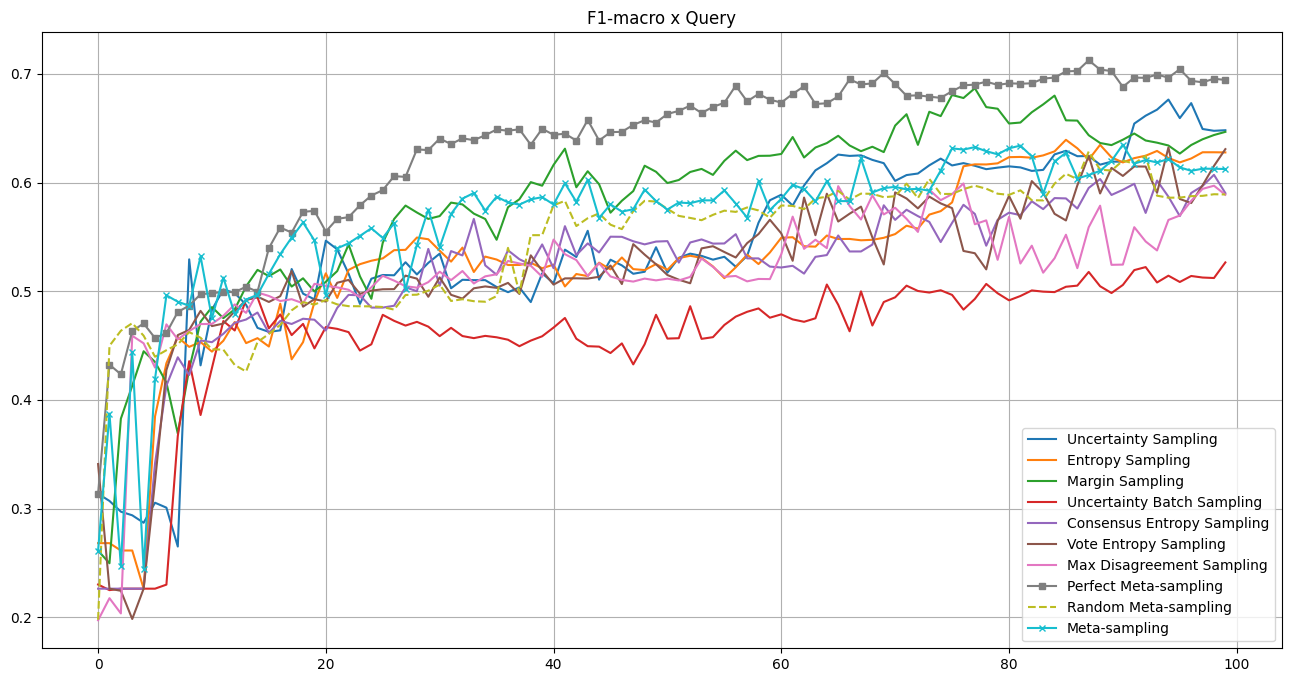

In [31]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, markersize=5,style=styles,  figsize=(16,8), title='F1-macro x Query')

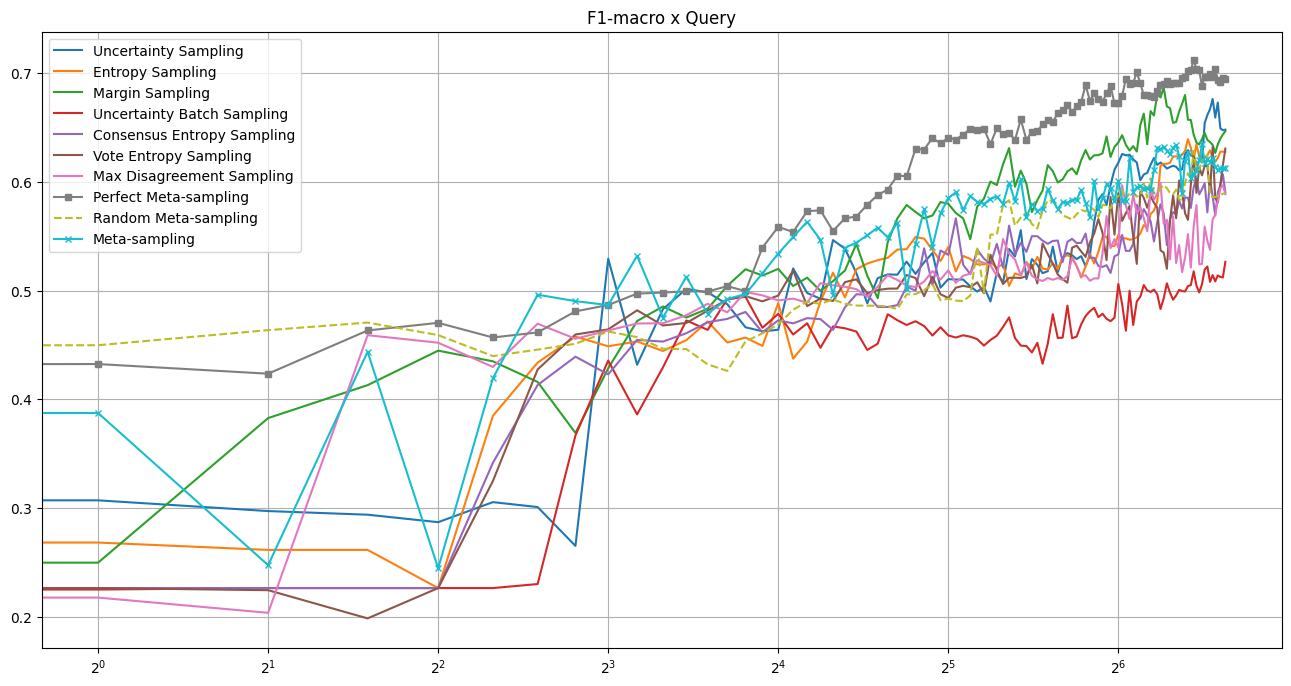

In [32]:
ax = pd.DataFrame(metrics_dict).plot(grid=True, style=styles, markersize=5, figsize=(16,8), title='F1-macro x Query')
ax.set_xscale('log', base=2)

In [55]:
gain_df = pd.DataFrame(metrics_dict).iloc[:, -3:]
baseline_column = gain_df['Random Meta-sampling']

gain_df = gain_df.apply(lambda x: x - baseline_column, axis=0)
gain_df

,Perfect Meta-sampling,Random Meta-sampling,Meta-sampling
0,0.115891,0.0,0.063488
1,-0.017333,0.0,-0.062369
2,-0.040076,0.0,-0.216254
3,-0.007276,0.0,-0.026899
4,0.011295,0.0,-0.214582
...,...,...,...
95,0.118118,0.0,0.027768
96,0.106145,0.0,0.023350
97,0.104463,0.0,0.024942
98,0.106297,0.0,0.023457


<Axes: title={'center': 'Ganho F1-macro x Query'}>

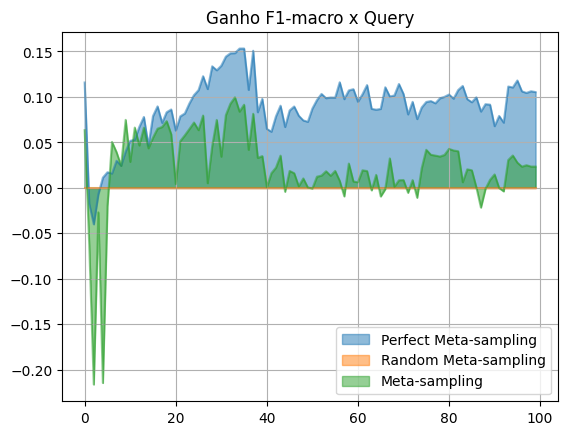

In [74]:
gain_df.plot.area(stacked=False, grid=True , title="Ganho F1-macro x Query")